# Grid search on the TD's parameters
This Notebook contains the code needed to perform the grid search for the temporal difference learning.

We will perform a grid search on 3 parameters:
    - stepSize: it is the learning rate (alpha in the Q-learning algorithm)
    - epsilon: the percentage of exploratory moves for the epsilon-greedy policy (for the learning)
    - opp_epsilon: the percentage of random moves done by the opponent during the learning phase (the rest are optimal)
The first two are hyperparameters of the algorithm, while the last one is a bit more arbitrary, but can still be seen as a parameter to tune in order to improve the learning.
The evaluation of each set of parameters is based on the F-Score obtain after learning from a fixed number of runs.

## 1 - Initialization
In this first part we initialize the variables and function needed.
The range of values for the parameters, as well as the number of evaluations can be modified here, under "Variables initialization". However, note that the maximum range of every parameter is [0,1].
Moreover, it is possible to change the number of run after which the learning should stop. A low number may cause the learnings to be inefficient, while one too high will cause the grid search to be slow and might even prevent from discriminating correctly the performances between sets of parameters by giving most of them enough time to achieve optimality.

In [1]:
# import general librairies
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
from IPython.display import clear_output
# personal librairies
from SA import SA
from AgentQ import AgentQ
from Opponent import Opponent

# Variables initialization
# Reinforcement learning
discount = 1 # no discounting (gamma)
##################################################
stepSize = [i for i in np.linspace(0,1,11)] # alpha , the learning rate
epsilon =  [i for i in np.linspace(0,1,11)] # for the epsilon-greedy policy
opp_epsilon = [i for i in np.linspace(0,1,4)] # fraction of randomness for the opponent of the learning phase
##################################################
# Nim
board_ini = sorted([5,5,5,5]) # Biggest board for learning Nim
##################################################
runMax = int(1E4) # Number of runs for the learning
##################################################

# Function initialization
def init_board():
    """
    Return a random board based on board_ini
    """
    for i in range(len(board_ini)):
        board[i] = rnd.randint(0,board_ini[i])
    board.sort()
    
    if board[-1] == 0:
        return init_board()
    return board

## 2 - Grid search
The grid search is done in this section. To keep track of the evaluations, a counter is shown in the ouput. Be careful as it might take some time (usually a few minutes).

In [2]:
# Board and agent
board = list(board_ini)
board_end = [0] * len(board_ini)
optMoveFound_gridSearch = np.zeros((len(stepSize),len(epsilon),len(opp_epsilon)))
searchNb = 0

# Learn for each set of parameters
for ii in range(len(stepSize)):
    for jj in range(len(epsilon)):
        for kk in range(len(opp_epsilon)):
            searchNb += 1
            
            agent = AgentQ(SA(board), stepSize[ii], discount, epsilon[jj])
            oppLearning = Opponent(SA(board), policy="e-optimal", epsilon=opp_epsilon[kk])
            
            # the learning
            for run in range(runMax):
                if (run+1) % 1000 == 0:
                    clear_output()
                    print("search: {}/{}\n".format(searchNb, len(stepSize)*len(epsilon)*len(opp_epsilon)))
                    print("run   : {}/{}\n\n".format(run+1, runMax))
                
                board = init_board()
                
                agentIsFirst = rnd.randint(0,1)
                if agentIsFirst == False:
                    oppLearning.move(board)
                    if board == board_end:
                        continue
                
                while True:
                    agent.move(board)
                    if board == board_end:
                        agent.winUpdate()
                        break
                    
                    oppLearning.move(board)
                    if board == board_end:
                        agent.loseUpdate()
                        break
                        
                    agent.updateQ(board)
             
            # Compute the F-score after the learning for that particular set of parameters
            optMove_P = 0.
            optMove_TP = 0.
            optMove_FP = 0.
            for s in agent.states:
                board = list(agent.states[s])
                for heap in range(len(board)):
                    for action in range(1,1+board[heap]):
                        temp_board = list(board)
                        temp_board[heap] -= action
                                  
                        nimSum = 0
                        for i in range(len(temp_board)):
                            nimSum ^= temp_board[i]
                        
                        a = agent.actions.index([heap,action])
                        if nimSum == 0:
                            optMove_P += 1.
                            if agent.Q[s][a] >= 0.9:
                                optMove_TP += 1.
                        elif agent.Q[s][a] >= 0.9:
                            optMove_FP += 1.
            
            optMoveFound_Recall = optMove_TP/optMove_P
            if optMove_TP+optMove_FP == 0.:
                optMoveFound_Precision = 0.
            else:
                optMoveFound_Precision = optMove_TP/(optMove_TP+optMove_FP)
            if optMoveFound_Precision+optMoveFound_Recall == 0:
                optMoveFound_F = 0.
            else:
                optMoveFound_F = 2*optMoveFound_Precision*optMoveFound_Recall / \
                                  (optMoveFound_Precision+optMoveFound_Recall)
            
            optMoveFound_gridSearch[ii,jj,kk] = optMoveFound_F

search: 484/484

run   : 10000/10000




## 3 - Plot of the results
And finally we plot the results of the grid search. As there are 3 parameters, we plot multiple 2D graphs. For each graph, the optimality of the opponent is fixed, and we plot the step size vs. the exploration term.
After, the programs return the best set of parameters it has found among the ones it tested (if there are equality, it returns only the first seen).

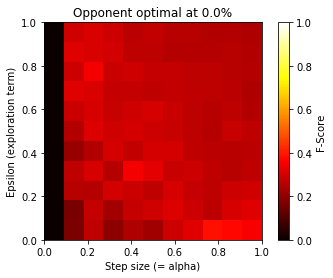

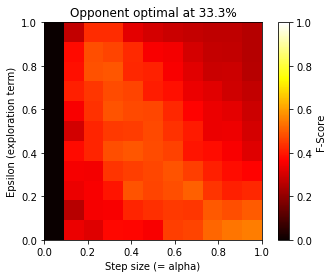

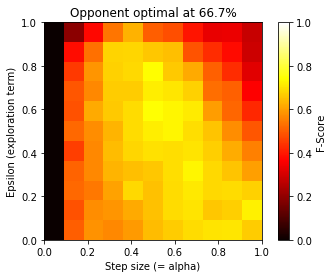

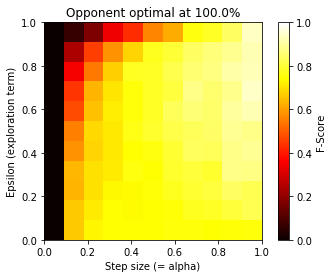

The optimal parameters are found to be:
   - step size = 1.0   (= alpha, the learning rate)
   - epsilon = 0.7     (the exploration term during learning)
   - opp_epsilon = 0.0 (the fraction of randomness of the opponent)


In [7]:
# Plot multiple 2D graphs
for i in range(len(opp_epsilon)):
    plt.imshow(optMoveFound_gridSearch[:,:,-1-i].T, origin='lower', extent=(stepSize[0], stepSize[-1], epsilon[0], epsilon[-1]), \
               vmin=0., vmax=1., interpolation='none', cmap='hot')
    cbar = plt.colorbar(); cbar.set_label("F-Score")
    plt.xlabel("Step size (= alpha)"); plt.ylabel("Epsilon (exploration term)")
    plt.title("Opponent optimal at {:.1f}%".format((1.-opp_epsilon[-1-i])*100.))
    plt.show()

# Look for the first best set of parameters
index_best = np.unravel_index(np.argmax(optMoveFound_gridSearch), optMoveFound_gridSearch.shape)
print "The optimal parameters are found to be:"
print "   - step size = {}   (= alpha, the learning rate)".format(stepSize[index_best[0]])
print "   - epsilon = {}     (the exploration term during learning)".format(epsilon[index_best[1]])
print "   - opp_epsilon = {} (the fraction of randomness of the opponent)".format(opp_epsilon[index_best[2]])